In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from llm_explore.utils import get_torch_device
from llm_explore.definitions import ROOT_DIR

2025-08-03 10:38:06.530 | INFO     | llm_explore.config:<module>:11 - PROJ_ROOT path is: /Users/zeromh/ds/llm_explore


In [2]:
device = get_torch_device()
torch.mps.manual_seed(42)

Returned MPS device


In [3]:
transforms = v2.Compose([
    v2.ToImage(),  # Convert to PIL image to tensor
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=(0.2860,), std=(0.3530,)),
])

training_data = datasets.FashionMNIST(root=Path(ROOT_DIR, 'data'),
    train=True, download=True, transform=transforms)
test_data = datasets.FashionMNIST(root=Path(ROOT_DIR, 'data'),
    train=False, download=True, transform=transforms)    

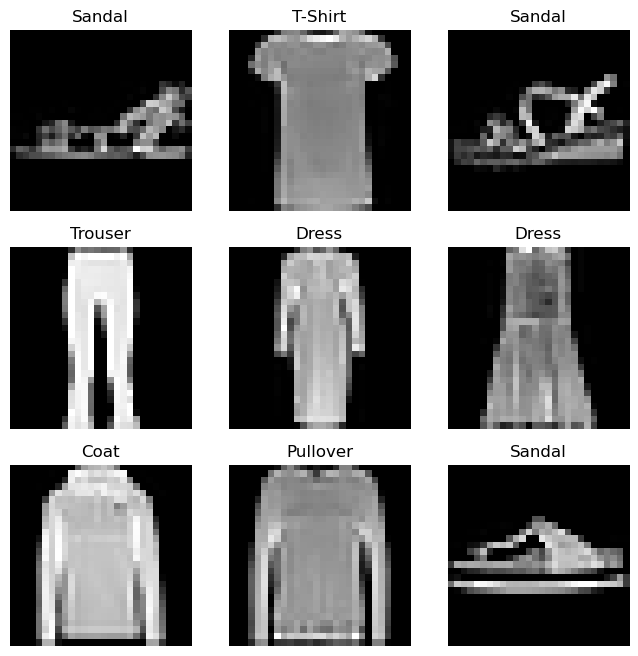

In [21]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3 # for charting 9 images
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
img, label = training_data[0]
print(img.shape, label)

In [32]:
for i, (X, y) in enumerate(test_dataloader):
    print(i, X.shape, y.shape)
    break

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [7]:
y

tensor([5, 4, 7, 0, 0, 2, 2, 7, 3, 7, 5, 1, 5, 9, 4, 5, 5, 9, 7, 6, 1, 5, 6, 2,
        9, 2, 1, 2, 2, 2, 6, 2, 3, 0, 5, 7, 0, 6, 7, 3, 0, 3, 5, 1, 7, 1, 0, 9,
        6, 6, 5, 6, 1, 2, 1, 8, 2, 3, 3, 8, 6, 2, 4, 8])

In [7]:
class MLP1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        #self.bn = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x, y=None):
        out = self.flatten(x)
        out = self.linear1(out)
        #out = self.bn(out)
        out = self.relu(out)
        logits = self.linear2(out)
        loss = None
        if y is not None:
            loss = self.loss_fn(logits, y)
        return logits, loss
    


In [8]:
model = MLP1(input_dim=28*28, hidden_dim=512, output_dim=10)
model.to(device)

MLP1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [7]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


In [19]:
for p in model.named_parameters():
    print(p[0], p[1].shape)

linear1.weight torch.Size([512, 784])
linear1.bias torch.Size([512])
linear2.weight torch.Size([10, 512])
linear2.bias torch.Size([10])


In [ ]:
# # From copilot, not sure if correct
# class FashionMNISTModel(nn.Module):
#     def __init__(self):
#         super(FashionMNISTModel, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28 * 28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [15]:
optimizer = optim.SGD(model.named_parameters(), lr=.01)
# Changing lr from .05 to .01

In [16]:
train_dataloader.dataset.data.shape[0]

60000

In [ ]:
num_epochs = 15
train_sample_size = train_dataloader.dataset.data.shape[0]
test_sample_size = test_dataloader.dataset.data.shape[0]
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    epoch_test_loss = 0
    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits, loss = model(X, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(epoch_loss/train_sample_size)
    
    # Compute test loss
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            logits, loss = model(X, y)
            epoch_test_loss += loss.item()
    test_losses.append(epoch_test_loss/test_sample_size)

100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


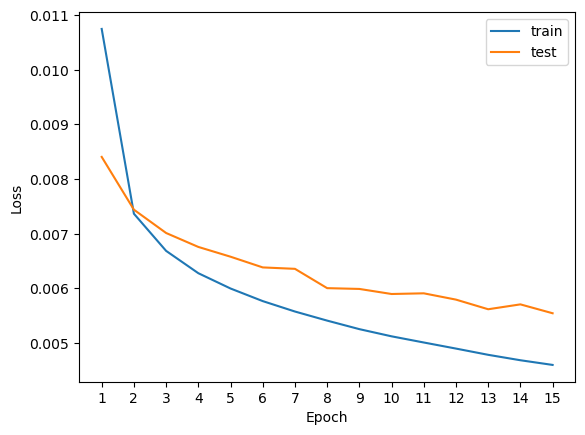

In [26]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.xticks(range(len(train_losses)), 
           [str(i+1) for i in range(len(train_losses))]) 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test']);

In [ ]:
# Save model
#torch.save(model.state_dict(), Path(ROOT_DIR,"models", "mlp1_fashionmnist.pth"))

# Later, to load:
# model = MLP1(input_dim=28*28, hidden_dim=512, output_dim=10)
# model.load_state_dict(torch.load(Path(ROOT_DIR, "models/mlp1_fashionmnist.pth")))
# model.to(device)
# model.eval()  # Set to evaluation mode if needed

MLP1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [11]:
# Load some data into X
for (X, y) in test_dataloader:
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [12]:
model.eval()
with torch.no_grad():
    logits, _ = model(X.to(device))
    preds = logits.argmax(dim=1)
    print("Predicted:", preds.cpu().numpy())
    print("Actual:   ", y.cpu().numpy())

Predicted: [3 7 3 7 8 1 3 0 4 1 7 0 2 0 9 7 5 6 5 7 8 8 0 8 5 0 0 3 7 4 0 7 1 8 5 2 6
 0 3 6 0 0 5 7 5 1 4 2 6 9 9 5 7 3 0 0 1 5 4 6 7 7 4 2]
Actual:    [3 7 3 7 8 1 3 0 4 1 7 0 4 0 9 7 5 0 5 7 8 8 0 8 5 0 0 3 7 4 6 7 1 8 5 2 6
 0 3 6 0 0 5 7 5 1 3 2 6 9 9 5 7 3 0 0 3 5 2 6 7 7 4 2]


In [13]:
def logit_to_probability(logit):
  """
  Converts a logit value to a probability.

  Args:
    logit: The logit (log-odds) value.

  Returns:
    The corresponding probability.
  """
  probability = 1 / (1 + np.exp(-logit))
  return probability

def softmax(logits):
    """
    Converts a vector of logits into a vector of softmax probabilities.

    Args:
        logits (np.array): A 1D NumPy array representing the raw scores (logits).

    Returns:
        np.array: A 1D NumPy array representing the softmax probabilities.
    """
    # Subtract the maximum logit for numerical stability to prevent overflow
    # when computing exponentials of large positive numbers.
    exp_logits = np.exp(logits - np.max(logits))
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

In [14]:
scores = pd.DataFrame(logits.cpu().numpy())
scores = scores.apply(lambda x: softmax(x), axis=1).round(4)
scores['highest_prob'] = scores.max(axis=1)
scores['pred'] = preds.cpu().numpy()
scores['actual'] = y.cpu().numpy()
scores['correct'] = (scores.pred==scores.actual).astype(int)
scores.head()

,0,1,2,3,4,5,6,7,8,9,highest_prob,pred,actual,correct
0,0.1008,0.0028,0.0011,0.8828,0.0009,0.0000,0.0090,0.0000,0.0026,0.0000,0.8828,3,3,1
1,0.0001,0.0000,0.0001,0.0000,0.0000,0.0286,0.0000,0.9663,0.0028,0.0020,0.9663,7,7,1
2,0.0440,0.0013,0.0378,0.6750,0.0426,0.0000,0.1827,0.0000,0.0166,0.0000,0.6750,3,3,1
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0063,0.0000,0.9928,0.0001,0.0008,0.9928,7,7,1
4,0.0027,0.0000,0.0001,0.0000,0.0002,0.0001,0.0013,0.0000,0.9956,0.0000,0.9956,8,8,1


In [16]:
scores[scores.highest_prob < .92]

,0,1,2,3,4,5,6,7,8,9,highest_prob,pred,actual,correct
0,0.1008,0.0028,0.0011,0.8828,0.0009,0.0000,0.0090,0.0000,0.0026,0.0000,0.8828,3,3,1
2,0.0440,0.0013,0.0378,0.6750,0.0426,0.0000,0.1827,0.0000,0.0166,0.0000,0.6750,3,3,1
6,0.0129,0.0007,0.0195,0.5511,0.3794,0.0000,0.0359,0.0000,0.0006,0.0000,0.5511,3,3,1
8,0.0000,0.0001,0.1418,0.0001,0.7642,0.0000,0.0931,0.0000,0.0007,0.0000,0.7642,4,4,1
11,0.5307,0.0002,0.0014,0.0106,0.0000,0.0000,0.4571,0.0000,0.0001,0.0000,0.5307,0,0,1
12,0.0000,0.0004,0.5000,0.0001,0.4971,0.0000,0.0022,0.0000,0.0001,0.0000,0.5000,2,4,0
17,0.1080,0.0000,0.0101,0.0047,0.0003,0.0000,0.8759,0.0000,0.0010,0.0000,0.8759,6,0,0
25,0.5947,0.0001,0.0241,0.1957,0.0018,0.0000,0.1829,0.0000,0.0007,0.0000,0.5947,0,0,1
26,0.7984,0.0002,0.0098,0.0058,0.0002,0.0000,0.1853,0.0000,0.0002,0.0000,0.7984,0,0,1
27,0.0675,0.0016,0.0246,0.8811,0.0120,0.0000,0.0117,0.0000,0.0014,0.0000,0.8811,3,3,1


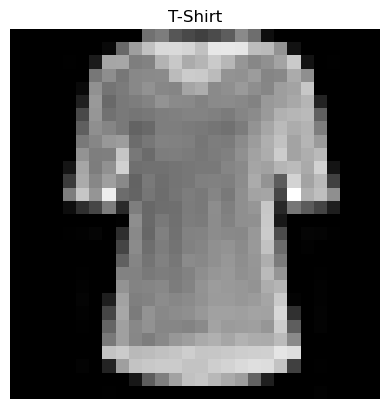

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
ix = 26
img, label = X[ix], int(y[ix].numpy())
plt.title(labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# When is it faster to send data to device? Does it matter for just
# computing logits/loss? 

# yingbo's base rate is .07  (relevant for baseline cross entropy). She uses base e for cross entropy tho. 
# Pytorch also uses base e for crossEntroypLoss.


# start video 1 at 1:50
# Model is not really getting better. Troubleshoot!


# Notes
# datasets.FashionMNIST does the transform on the spot when you grab the data,
# so if you look at data.data, it's untransformed. When you grab indexes,
# it's transformed.